# Assignment 2: Imaging Pipeline

MIDS W281: Computer Vision

## Recommended Libraries

In [5]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
from glob import glob

## Part 1: Demosaicing

![Bayer Pattern](images/bayer_pattern.png)

### Overview
In this exercise you will convert a raw sensor image into a full color image using demosaicing. Digital sensors record color images through a Bayer mosaic (above), where each pixel records only one of the three color colors (RGB). A software interpolation is then needed to reconstruct all three colors at each pixel.

**HINT:** There are different Bayer mosaic patterns than the one shown above.  You should look into them and try them out.

### Description: 
We will provide you with some raw images, represented as grayscale images (red, green, and blue pixels are all on the same channel of the image). Your task is to write some python code to demosaic and generate a full three-channel RGB image. You're encouraged to debug your code using the image `signs-small.png` because it is not very large and exhibits some interesting challenges of demosaicing. Note that you may need to convert images between `UINT8` and `float32` data types for computation and visualization.

For simplicity we will ignore the pixels at the boundary of the image, specifically the first and last two rows and columns don't need to be reconstructed. This will allow you to focus on the general case and not worry about whether neighboring values are unavailable. It's actually not uncommon for cameras and software to return a slightly-cropped image for similar reasons. Therefore, for an image of size NxN, you will return a cropped image of size (N-2)x(N-2)x3.  

1. Write a python function that takes as input a raw image and offset and returns a single-channel 2-D image corresponding to the interpolated green channel. The offset encodes whether either the top-left pixel or its right neighbor is the first green pixel. In our case (Figure 1) the second pixel is green, so offset=1.  

2. Write another python function for generating the red and blue channels. This function takes a raw image and two offsets: one for row offset and one for column offset, and returns a single-channel image. The row/column offset for the red channel is (0,0) and for the blue channel (1,1) (see Figure 1). Note that the interpolation for the red/blue channel will be different than the green channel because the recorded pixels are sparser. For interpolated pixels that have two direct neighbors that are known (left-right or up-down), simply take the linear average between the two values. For the remaining case, average the four diagonal pixels. You can ignore the first and last two rows or columns to make sure that you have all the neighbors you need. Similar to the green-channel, interpolate the values when they are missing and copy the values when they are available.  

3. Using the above two functions, create a full three-channel, RGB image. You might observe some checkerboard artifacts around strong edges. This is expected from our naive interpolation approach.

### Deliverables:
- Python code for interpolation of green channel and red/blue channel
- Full-three channel RGB image for `signs.png` (**THE BIG ONE, NOT THE SMALL ONE**)

Data Type:  float32
Image Size:  (2014, 3039)
Data Type:  uint8
Image Size:  (2012, 3037, 3)


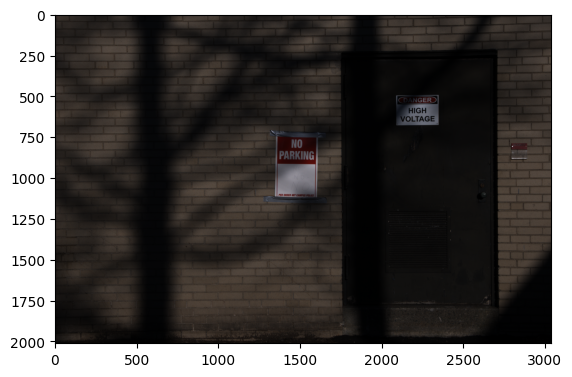

In [6]:
def interpolate_green(raw_img, offset_value):
    # Create an empty image container
    green_img = np.zeros_like(raw_img, dtype=np.float32)
    # Gain the row and col values
    row_loc, col_loc = raw_img.shape
    # Iterations
    for row_index in range(1, row_loc-1):
        for col_index in range(1, col_loc-1):
            # Replicate the green value to green_channel_matrix
            if (row_index + col_index + offset_value) % 2 == 0:
                green_img[row_index, col_index] = raw_img[row_index, col_index]
            # Perform interpolation for non-green value grid
            else:
                green_img[row_index, col_index] = (raw_img[row_index, col_index-1] +
                                                   raw_img[row_index, col_index+1] +
                                                   raw_img[row_index-1, col_index] +
                                                   raw_img[row_index+1, col_index]) / 4
    # Crop the image
    green_img = green_img[1:-1, 1:-1]
    return green_img

def interpolate_redblue(raw_img, offset_pair):
    # Create an empty image container
    redblue_img = np.zeros_like(raw_img, dtype=np.float32)
    # Gain the row and col values
    row_loc, col_loc = raw_img.shape
    row_offset, col_offset = offset_pair
    
    # Iterations
    for row_index in range(1, row_loc-1):
        for col_index in range(1, col_loc-1):
            
            if (row_index + row_offset) % 2 == 0 and (col_index + col_offset) % 2 == 0:
                redblue_img[row_index, col_index] = (raw_img[row_index-1, col_index-1] +
                                                     raw_img[row_index-1, col_index+1] +
                                                     raw_img[row_index+1, col_index-1] +
                                                     raw_img[row_index+1, col_index+1]) / 4
            
            elif (row_index + row_offset) % 2 != 0 and (col_index + col_offset) % 2 == 0:
                redblue_img[row_index, col_index] = (raw_img[row_index, col_index-1] +
                                                     raw_img[row_index, col_index+1]) / 2
            
            elif (row_index + row_offset) % 2 == 0 and (col_index + col_offset) % 2 != 0:
                redblue_img[row_index, col_index] = (raw_img[row_index-1, col_index] +
                                                     raw_img[row_index+1, col_index]) / 2  
            
            else:
                redblue_img[row_index, col_index] = raw_img[row_index, col_index]  

    # Crop the image
    redblue_img = redblue_img[1:-1, 1:-1]
    return redblue_img

# load images
test_img = plt.imread('./demosaicing/signs-small.png')
raw_img = plt.imread('./demosaicing/signs.png')

img = raw_img.copy()
# TODO: check img data type
print("Data Type: ", img.dtype)
print("Image Size: ", img.shape)
# convert the datat type if it is not float32
if img.dtype != np.float32:
    img = img.astype(np.float32) / 255

# Perform extractions
green_offset = 1
green_img = interpolate_green(img, green_offset)

blue_offset = [1, 1]
blue_img = interpolate_redblue(img, blue_offset)

red_offset = [0, 0]
red_img = interpolate_redblue(img, red_offset)

color_img = np.dstack((red_img, green_img, blue_img))
# Convert to unit8 for visualization
color_img = (color_img  * 255).astype(np.uint8)
print("Data Type: ", color_img.dtype)
print("Image Size: ", color_img.shape)
# Show the image
plt.imshow(color_img)
plt.show()

## Part 2: Denoising

![Denoising Teaser](images/denoising.png)

### Overview
Random noise is a problem that often arises in cameras specially in extremely low light conditions, and its presence can seriously degrade the quality of a digital image. To remedy the situation, an average of multiple images, captured very close in time, can be used to improve the quality final image. Because the camera may move while recording mulitple images, we will need to align the images before averaging and denoising. We will implement this alignment + denoising algorithm.

### Description: 
We provide 18 images captured in a low light setting. One of the images is shown above.

Each image is slightly mis-aligned from the previous image in the sequence. Our goal is to align each of the images in the sequence to the first image and then average the aligned images to reduce the noise (which tends to be independent across images). Note that you may need to convert images between `UINT8` and `float32` data types for computation and visualization.

1. Write a python function that takes as input two images and returns the horizontal and vertical offset that best aligns the two images. Ignore the difference for all the pixels less than or equal to a `maxOffset` away from the edges. Use a brute force approach that tries every possible integer translation and evaluates the quality of a match using the squared error norm (the sum of the squared pixel differences). You can set the `maxOffset` to 15 pixels.  
2. Align each image to the first image and denoise by averaging all of the aligned images.


### Deliverables:

- Python code to align noisy images
- Aligned and de-noised average image

Data Type:  float32
Data Type:  float32
Data Type:  float32
Data Type:  float32
Data Type:  float32
Data Type:  float32
Data Type:  float32
Data Type:  float32
Data Type:  float32
Data Type:  float32
Data Type:  float32
Data Type:  float32
Data Type:  float32
Data Type:  float32
Data Type:  float32
Data Type:  float32
Data Type:  float32
Data Type:  float32


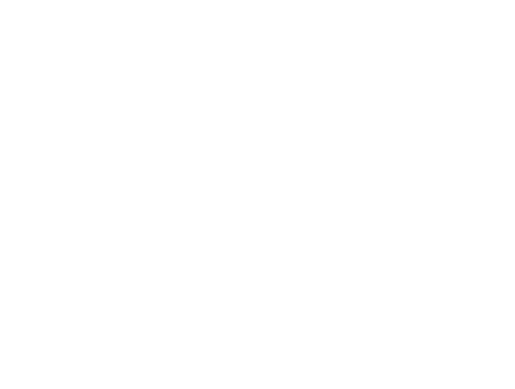

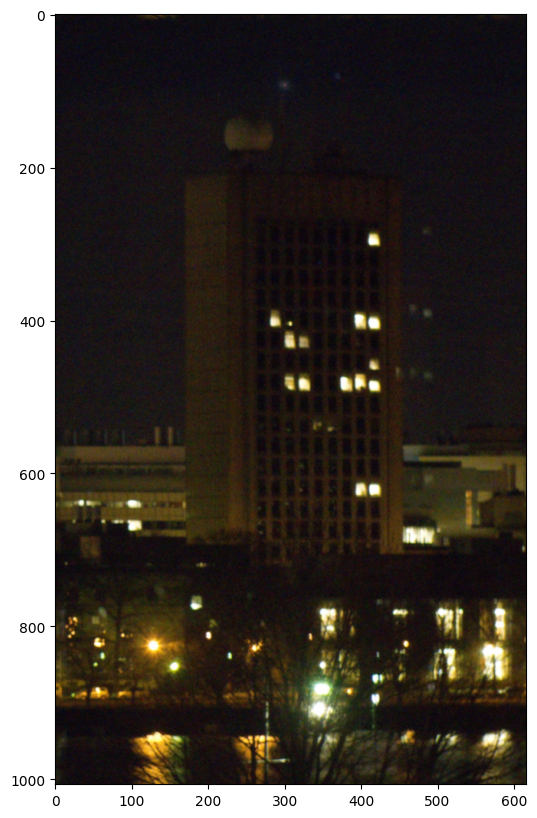

In [7]:
# load images
img_list = sorted(glob('./denoising/*.png'))
img_ref = plt.imread(img_list[0])

# TODO: use a for-loop to load remaining images and check data types
for i,img in enumerate(img_list):
    print("Data Type: ", plt.imread(img).dtype)
    
def align_imgs(img1, img2, maxOffset):
    # TODO: use nested for-loops to compute the error for every possible
    # combination of x and y offsets, up to the maxOffset in each dimension
    # The function np.roll may be helpful for shifting the images relative to each other
    # For each offset, compute the squared error norm
    
    # set an initial value for the error and offset
    best_offset = (0, 0)
    best_error = float('+inf')
    
    # Iterate to compute the offsets
    for offset_y in range(-maxOffset, maxOffset + 1): # up and down
        for offset_x in range(-maxOffset, maxOffset + 1): # left and right
            # shift the image
            shifted_img = np.roll(img2, (offset_y, offset_x), axis = (0,1))
            # subtract
            difference = img1 - shifted_img
            # crop the valid region
            if offset_x >= 0 and offset_y >= 0:
                difference = difference[offset_y:,offset_x:]
            elif offset_x < 0 and offset_y >= 0:
                difference = difference[offset_y:,:offset_x]
            elif offset_x >= 0 and offset_y < 0:
                difference = difference[:offset_y,offset_x:]
            else:
                difference = difference[:offset_y,:offset_x]
    
            error = np.sum(difference**2)
            # record the result if it is best
            if error <= best_error:
                best_error = error
                best_offset = (offset_y, offset_x)
    
    
    return best_offset, best_error

def combine_imgs(img_list, offset_list):
    # TODO: for each image, shift it by the corresponding offset from align_imgs
    # Compute the mean across all offset images
    # Note that you do not need to make an array containing all images
    # It is computationally cheaper to add the weighted pixel values to a running sum image
    
    # create an image template matrix with zeros
    sum_img = plt.imread(img_list[0])
    
    # Iterate to add the shifted images to the sum_img
    for img_path, offset_params in zip(img_list[1:], offset_list):
        img = plt.imread(img_path)
        offset_y = offset_params[0][0]
        offset_x = offset_params[0][1]
        img_shift = np.roll(img, (offset_y, offset_x), axis=(0, 1))
        sum_img += img_shift
    
    # compute the mean value
    composite_img = sum_img / len(img_list)
    
    return composite_img

# TODO: for each image in img_list, compute best_offset using align_imgs
# Use the resulting offset list to generate a composite image
offset_list = []
for img in img_list[1:]:
    # read image based on the path
    img_element = plt.imread(img)
    # check the data type and convert
    if img_element.dtype != np.float32:
        img_element = img_element.astype(np.float32) / 255
    # compute the alignments
    offset, best_error = align_imgs(img_ref, img_element, maxOffset=15)
    # append the results
    offset_list.append([offset, best_error])

# Combine images & convert to unit8
composite_img = combine_imgs(img_list, offset_list)
composite_img = (composite_img  * 255).astype(np.uint8)
# Show the image
plt.axis('off')
plt.figure(figsize = (20,10))
plt.imshow(composite_img)
plt.show()

## Part 3: White balance

Before WB

![WB Teaser](white_balance/input.png)

After WB

![WB Teaser](white_balance/output.png)

### Overview
Color constancy is one of the most amazing features of the human visual system. When we look at objects under different illuminations, their colors stay relatively constant. This helps humans to more easily identify objects under varying illuminations. A similar behavior is highly desirable in digital still and video cameras. This is achieved via white balancing, typically employed in a digital camera's imaging pipeline to adjust the coloration of images captured under different illuminations.

### Description 
You will implement two methods for white balancing, gray-world and white-patch, described below. The two images above show before and after white balancing using the gray-world assumption. You can test your white balancing code using this example image. Images which are white-balanced using the white-patch method will have a different appearance depending on the patch selected.

1. One simple technique for white balancing is based on the gray-world assumption. This assumption argues that the average reflectance of a scene is achromatic. In other words, the mean of the red, green, and blue channels in a given scene should be roughly equal. We will implement this white balancing technique. Write a function to automatically white balance an image using the gray-world assumption. You should multiply each color channel by a scale factor so that the resulting mean of each of the three color channels is the same and equal to the average value of the green channel of the input image.

2. Another method for white balancing uses a white-patch in the image. In this method, the user manually selects an image region which is supposed to be white but looks colored due to the scene illumination. As above, we will scale each color channel by a factor so that the average color of the selected region becomes white. Write a python code to implement the white-patch balancing method. Your code should take in a location in the image and use a fixed-sized region around that point to compute the target white point.

In both cases, you will need to account for pixel values that fall outside the displayable range after transformation. You should clip these values rather than scaling them.

Please specify the region that you selected in your code for 2.

### Deliverables:

- Python functions for gray-world and white-patch white balancing
- Output images after white balancing the image `white_balance/input.png` using both gray-world and white-patch methods

Data Type:  float32


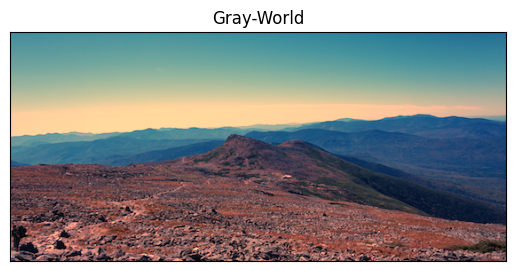

Regions Selection:  [100:105,100:105]
 - Reason for choosing: this region should be the white cloud


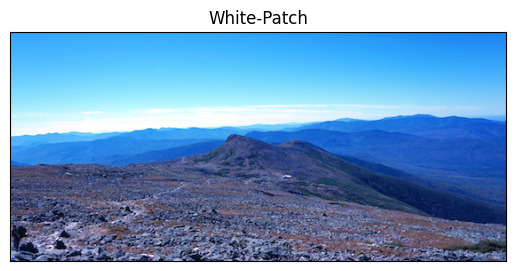

In [8]:
# load image
input_img = plt.imread('./white_balance/input.png')
# TODO: check img data type
print("Data Type: ", input_img.dtype)
# convert the datat type if it is not float32
if input_img.dtype != np.float32:
    input_img = input_img.astype(np.float32) / 255

def gray_world(input_img):
    # TODO: get average green value
    # compute scale factor for red and blue
    # rescale red and blue channels
    
    # Compute the mean values
    red_mean = np.mean(input_img[:, :, 0])
    green_mean = np.mean(input_img[:, :, 1])
    blue_mean = np.mean(input_img[:, :, 2])
    
    # Generate the scale factor based on the green mean value
    scaled_red_factor = green_mean / red_mean
    scaled_blue_factor = green_mean / blue_mean
    
    # Multiply the scaled factor to corresponding channels
    revised_red_channel = scaled_red_factor * input_img[:, :, 0]
    revised_blue_channel = scaled_blue_factor * input_img[:, :, 2]
    
    # stack the new channels to formulate RGB images
    wb_img = np.dstack((revised_red_channel,input_img[:, :, 1],revised_blue_channel))
    
    # Clip values for the range between [0,1]
    wb_img = np.clip(wb_img, 0, 1)
    
    # return the wb_img
    return wb_img

def white_patch(input_img):
    # TODO: get point(s) from user
    # compute scale factors for each color channel
    # rescale each color channel
    
    # Copy the image
    wb_img = input_img.copy()
    
    # Select the patch
    patch = input_img[100:105,100:105]
    
    # Compute scale factors for each color channel
    scale_factor = 1 / np.mean(patch, axis=(0, 1))
    
    # scale all pixels in channels
    wb_img[:, :, 0] = scale_factor[0] * input_img[:, :, 0] # Red Channel
    wb_img[:, :, 1] = scale_factor[1] * input_img[:, :, 1] # Green Channel
    wb_img[:, :, 2] = scale_factor[2] * input_img[:, :, 2] # Blue Channel
    
    # Clip values for the range between [0,1]
    wb_img = np.clip(wb_img, 0, 1)
    
    # return the wb_img
    return wb_img

# Call functions and convert to unit 8 for display
gray_world_output = (gray_world(input_img) * 255).astype(np.uint8)
white_patch_output = (white_patch(input_img) * 255).astype(np.uint8)

# Plotting Gray World
fig1 = plt.figure()
plt.imshow(gray_world_output)
plt.xticks(ticks=[])
plt.yticks(ticks=[])
plt.title('Gray-World')
plt.show()

# Plotting White Patch
print("Regions Selection: ", "[100:105,100:105]\n - Reason for choosing: this region should be the white cloud")
fig2 = plt.figure()
plt.imshow(white_patch_output)
plt.xticks(ticks=[])
plt.yticks(ticks=[])
plt.title('White-Patch')
plt.show()

#### Acknowledgments
This assignment is based on an assignment for Computational Aspects of Digital Photography class by Prof. Wojciech Jarosz at Dartmouth College.